#  Contextual bandit for airliner's flight operations

<b> Requirements</b>

vowpalwabbit==9.8.0
<br>torch=1.13.1

In [1]:
import vowpalwabbit
import torch
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np

### Define problem parameters

In [2]:
# Shared Context
flight_types = ['domestic', 'international']
passenger_classes = ['business', 'economy', 'mix']

# Action Options
flight_routes = ['direct', 'fuel_efficient', 'turbulence_avoidance']
meal_services = ['full_meal', 'simple_meal', 'snacks_beverages']
entertainment_options = ['movies_music', 'in_flight_wifi', 'combo']

### Reward function

In [3]:
def reward_function(shared_context, flight_route, meal_service, entertainment_option):
    # Reward Mapping for Flight Route
    if flight_route == 'direct':
        route_reward = np.random.normal(loc=0.9, scale=0.05)
    elif flight_route == 'fuel_efficient':
        route_reward = np.random.normal(loc=0.8, scale=0.05)
    else:  # turbulence_avoidance
        route_reward = np.random.normal(loc=0.7, scale=0.05)

    # Reward Mapping for Meal Service
    if meal_service == 'full_meal':
        meal_reward = np.random.normal(loc=0.9, scale=0.05)
    elif meal_service == 'simple_meal':
        meal_reward = np.random.normal(loc=0.8, scale=0.05)
    else:  # snacks_beverages
        meal_reward = np.random.normal(loc=0.7, scale=0.05)

    # Reward Mapping for In-Flight Entertainment
    if entertainment_option == 'movies_music':
        entertainment_reward = np.random.normal(loc=0.9, scale=0.05)
    elif entertainment_option == 'in_flight_wifi':
        entertainment_reward = np.random.normal(loc=0.8, scale=0.05)
    else:  # combo
        entertainment_reward = np.random.normal(loc=0.7, scale=0.05)

    # Overall Reward as the average of individual rewards
    reward = (route_reward + meal_reward + entertainment_reward) / 3.0

    return reward

### Generate combinations

In [4]:
def generate_combinations(shared_context, flight_routes, meal_services, entertainment_options):
    examples = [f"shared |FlightType {shared_context[0]} PassClass {shared_context[1]}"]
    descriptions = []
    for route in flight_routes:
        for meal in meal_services:
            for entertainment in entertainment_options:
                examples.append(f"|Action route={route} meal={meal} entertainment={entertainment}")
                descriptions.append((route, meal, entertainment))
    return examples, descriptions

### Sample using probabilistic matrix factorization (pmf)

In [6]:
def sample_truck_pmf(pmf):
    pmf_tensor = torch.tensor(pmf)
    index = torch.multinomial(pmf_tensor, 1).item()
    chosen_prob = pmf[index]
    
    return index, chosen_prob

### Create a contexual bandit

Vowpal Wabbit offers five exploration algorithms:

Explore-First: --first

Epsilon-Greedy: --epsilon

Bagging Explorer: --bag

Online Cover: --cover

Softmax Explorer: --softmax (only supported for --cb_explore_adf)

In [7]:
cb_vw = vowpalwabbit.Workspace(
    "--cb_explore_adf --epsilon 0.2 --interactions AA AU AAU -l 0.05 --power_t 0",
    quiet=True,
)

### Run the CB

In [8]:
num_iterations = 2500
cb_rewards = []
for _ in range(num_iterations):
    shared_context = (random.choice(flight_types), random.choice(passenger_classes))
    examples, indices = generate_combinations(
        shared_context, flight_routes, meal_services, entertainment_options
    )
    cb_prediction = cb_vw.predict(examples)
    chosen_index, prob = sample_truck_pmf(cb_prediction)
    route, meal, entertainment = indices[chosen_index]
    reward = reward_function(shared_context, route, meal, entertainment)
    cb_rewards.append(reward)
    examples[chosen_index + 1] = f"0:{-1*reward}:{prob} {examples[chosen_index + 1]}"
    cb_vw.learn(examples)
cb_vw.finish()

### Plot the average reward

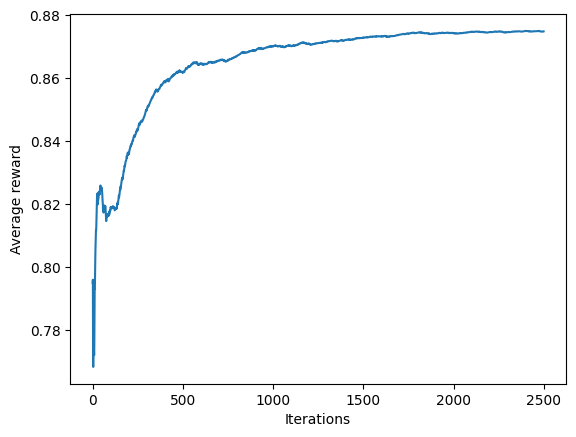

In [9]:
plt.plot(pd.Series(cb_rewards).expanding().mean())
plt.xlabel("Iterations")
plt.ylabel("Average reward")
plt.show()

### Use trained model to perform predictions on a test set

In [10]:
def test_model(shared_context, flight_routes, meal_services, entertainment_options):
    examples, _ = generate_combinations(shared_context, flight_routes, meal_services, entertainment_options)
    cb_prediction = cb_vw.predict(examples)
    chosen_index, prob = sample_truck_pmf(cb_prediction)
    chosen_action = examples[chosen_index + 1]
    route, meal, entertainment = indices[chosen_index]
    expected_reward = reward_function(shared_context, route, meal, entertainment)
    print("Chosen Action:", chosen_action)
    print("Expected Reward:", expected_reward)

# Test the model for a given shared context
test_shared_context = ('domestic', 'business')
test_model(test_shared_context, flight_routes, meal_services, entertainment_options)

Chosen Action: |Action route=fuel_efficient meal=full_meal entertainment=movies_music
Expected Reward: 0.8712098821251467
